In [1]:
import os
import cv2
import sys
import timm
import math
import glob
import torch
import random
import logging
import torchvision
import numpy as np
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.model_zoo as model_zoo
import torchvision.transforms as transforms

from datetime import datetime
from torch.autograd import Variable
from PIL import Image
from functools import partial
from scipy.ndimage.morphology import distance_transform_edt
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss, BCELoss
from scipy.ndimage.interpolation import zoom
from skimage.morphology import dilation, square, erosion

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg
from timm.models.registry import register_model

d:\torch_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\admin\AppData\Local\Temp\ipykernel_10732\2916948848.py:23: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt
C:\Users\admin\AppData\Local\Temp\ipykernel_10732\2916948848.py:25: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


In [2]:
np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(profile="full")

In [3]:
__all__ = ['Res2Net', 'res2net50_v1b', 'res2net101_v1b', 'res2net50_v1b_26w_4s']

model_urls = {
    'res2net50_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net50_v1b_26w_4s-3cf99910.pth',
    'res2net101_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net101_v1b_26w_4s-0812c246.pth',
}


class Bottle2neck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, baseWidth=26, scale=4, stype='normal'):
        """ Constructor
        Args:
            inplanes: input channel dimensionality
            planes: output channel dimensionality
            stride: conv stride. Replaces pooling layer.
            downsample: None when stride = 1
            baseWidth: basic width of conv3x3
            scale: number of scale.
            type: 'normal': normal set. 'stage': first block of a new stage.
        """
        super(Bottle2neck, self).__init__()

        width = int(math.floor(planes * (baseWidth / 64.0)))
        self.conv1 = nn.Conv2d(inplanes, width * scale, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width * scale)

        if scale == 1:
            self.nums = 1
        else:
            self.nums = scale - 1
        if stype == 'stage':
            self.pool = nn.AvgPool2d(kernel_size=3, stride=stride, padding=1)
        convs = []
        bns = []
        for i in range(self.nums):
            convs.append(nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, bias=False))
            bns.append(nn.BatchNorm2d(width))
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList(bns)

        self.conv3 = nn.Conv2d(width * scale, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stype = stype
        self.scale = scale
        self.width = width

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        spx = torch.split(out, self.width, 1)
        for i in range(self.nums):
            if i == 0 or self.stype == 'stage':
                sp = spx[i]
            else:
                sp = sp + spx[i]
            sp = self.convs[i](sp)
            sp = self.relu(self.bns[i](sp))
            if i == 0:
                out = sp
            else:
                out = torch.cat((out, sp), 1)
        if self.scale != 1 and self.stype == 'normal':
            out = torch.cat((out, spx[self.nums]), 1)
        elif self.scale != 1 and self.stype == 'stage':
            out = torch.cat((out, self.pool(spx[self.nums])), 1)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Res2Net(nn.Module):

    def __init__(self, block, layers, baseWidth=26, scale=4, num_classes=1000):
        self.inplanes = 64
        super(Res2Net, self).__init__()
        self.baseWidth = baseWidth
        self.scale = scale
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.AvgPool2d(kernel_size=stride, stride=stride,
                             ceil_mode=True, count_include_pad=False),
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                            stype='stage', baseWidth=self.baseWidth, scale=self.scale))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, baseWidth=self.baseWidth, scale=self.scale))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def res2net50_v1b(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b lib.
    Res2Net-50 refers to the Res2Net-50_v1b_26w_4s.
    Args:
        pretrained (bool): If True, returns a lib pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s']))
    return model


def res2net101_v1b(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s lib.
    Args:
        pretrained (bool): If True, returns a lib pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 23, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net101_v1b_26w_4s']))
    return model


def res2net50_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s lib.
    Args:
        pretrained (bool): If True, returns a lib pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model_state = torch.load('./Unet-CLearning/weights/res2net50_v1b_26w_4s-3cf99910.pth')
        model.load_state_dict(model_state)
        # lib.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s']))
    return model


def res2net101_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s lib.
    Args:
        pretrained (bool): If True, returns a lib pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 23, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net101_v1b_26w_4s']))
    return model


def res2net152_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s lib.
    Args:
        pretrained (bool): If True, returns a lib pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 8, 36, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net152_v1b_26w_4s']))
    return model


# MSNET

In [4]:
class CNN1(nn.Module):
    def __init__(self,channel,map_size,pad):
        super(CNN1,self).__init__()
        self.weight = nn.Parameter(torch.ones(channel,channel,map_size,map_size),requires_grad=False).cuda()
        self.bias = nn.Parameter(torch.zeros(channel),requires_grad=False).cuda()
        self.pad = pad
        self.norm = nn.BatchNorm2d(channel)
        self.relu = nn.ReLU()

    def forward(self,x):
        out = F.conv2d(x,self.weight,self.bias,stride=1,padding=self.pad)
        out = self.norm(out)
        out = self.relu(out)
        return out

class MSNet(nn.Module):
    # res2net based encoder decoder
    def __init__(self):
        super(MSNet, self).__init__()
        # ---- ResNet Backbone ----
        self.resnet = res2net50_v1b_26w_4s(pretrained=True)
        self.x5_dem_1 = nn.Sequential(nn.Conv2d(2048, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.x4_dem_1 = nn.Sequential(nn.Conv2d(1024, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.x3_dem_1 = nn.Sequential(nn.Conv2d(512, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.x2_dem_1 = nn.Sequential(nn.Conv2d(256, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.x5_x4 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.x4_x3 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.x3_x2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.x2_x1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))

        self.x5_x4_x3 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.x4_x3_x2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.x3_x2_x1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))

        self.x5_x4_x3_x2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.x4_x3_x2_x1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64),
                                         nn.ReLU(inplace=True))
        self.x5_dem_4 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.x5_x4_x3_x2_x1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64),
                                         nn.ReLU(inplace=True))

        self.level3 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.level2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.level1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.x5_dem_5 = nn.Sequential(nn.Conv2d(2048, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64),
                                      nn.ReLU(inplace=True))
        self.output4 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.output3 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.output2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.output1 = nn.Sequential(nn.Conv2d(64, 1, kernel_size=3, padding=1))

    def forward(self, x):
        input = x

        # '''
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x1 = self.resnet.maxpool(x)      # bs, 64, 88, 88
        # ---- low-level features ----
        x2 = self.resnet.layer1(x1)      # bs, 256, 88, 88
        x3 = self.resnet.layer2(x2)     # bs, 512, 44, 44
        x4 = self.resnet.layer3(x3)     # bs, 1024, 22, 22
        x5 = self.resnet.layer4(x4)     # bs, 2048, 11, 11
        # '''


        x5_dem_1 = self.x5_dem_1(x5)
        x4_dem_1 = self.x4_dem_1(x4)
        x3_dem_1 = self.x3_dem_1(x3)
        x2_dem_1 = self.x2_dem_1(x2)

        x5_4 = self.x5_x4(abs(F.upsample(x5_dem_1,size=x4.size()[2:], mode='bilinear')-x4_dem_1))
        x4_3 = self.x4_x3(abs(F.upsample(x4_dem_1,size=x3.size()[2:], mode='bilinear')-x3_dem_1))
        x3_2 = self.x3_x2(abs(F.upsample(x3_dem_1,size=x2.size()[2:], mode='bilinear')-x2_dem_1))
        x2_1 = self.x2_x1(abs(F.upsample(x2_dem_1,size=x1.size()[2:], mode='bilinear')-x1))


        x5_4_3 = self.x5_x4_x3(abs(F.upsample(x5_4, size=x4_3.size()[2:], mode='bilinear') - x4_3))
        x4_3_2 = self.x4_x3_x2(abs(F.upsample(x4_3, size=x3_2.size()[2:], mode='bilinear') - x3_2))
        x3_2_1 = self.x3_x2_x1(abs(F.upsample(x3_2, size=x2_1.size()[2:], mode='bilinear') - x2_1))


        x5_4_3_2 = self.x5_x4_x3_x2(abs(F.upsample(x5_4_3, size=x4_3_2.size()[2:], mode='bilinear') - x4_3_2))
        x4_3_2_1 = self.x4_x3_x2_x1(abs(F.upsample(x4_3_2, size=x3_2_1.size()[2:], mode='bilinear') - x3_2_1))

        x5_dem_4 = self.x5_dem_4(x5_4_3_2)
        x5_4_3_2_1 = self.x5_x4_x3_x2_x1(abs(F.upsample(x5_dem_4, size=x4_3_2_1.size()[2:], mode='bilinear') - x4_3_2_1))

        level4 = x5_4
        level3 = self.level3(x4_3 + x5_4_3)
        level2 = self.level2(x3_2 + x4_3_2 + x5_4_3_2)
        level1 = self.level1(x2_1 + x3_2_1 + x4_3_2_1 + x5_4_3_2_1)

        x5_dem_5 = self.x5_dem_5(x5)
        output4 = self.output4(F.upsample(x5_dem_5,size=level4.size()[2:], mode='bilinear') + level4)
        output3 = self.output3(F.upsample(output4,size=level3.size()[2:], mode='bilinear') + level3)
        output2 = self.output2(F.upsample(output3,size=level2.size()[2:], mode='bilinear') + level2)
        output1 = self.output1(F.upsample(output2,size=level1.size()[2:], mode='bilinear') + level1)

        output = F.upsample(output1, size=input.size()[2:], mode='bilinear')
        if self.training:
            return output
        return output


# DATALODER

In [5]:
class CustomDataset(data.Dataset):
    """
    dataloader for polyp segmentation tasks
    """
    def __init__(self, image_root, gt_root, trainsize, augmentations):
        self.trainsize = trainsize
        self.augmentations = augmentations
        print(self.augmentations)
        self.images = glob.glob(os.path.join(image_root, '*'))
        self.gts = glob.glob(os.path.join(gt_root, '*'))
        self.images = sorted(self.images)
        self.gts = sorted(self.gts)
        self.filter_files()
        self.size = len(self.images)
        if self.augmentations == 'True':
            print('Using RandomRotation, RandomFlip')
            self.img_transform = transforms.Compose([
                transforms.RandomRotation(90, resample=False, expand=False, center=None, fill=None),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize((self.trainsize, self.trainsize)),
                transforms.ToTensor()])
                # ,
                # transforms.Normalize([0.485, 0.456, 0.406],
                #                      [0.229, 0.224, 0.225])

            self.gt_transform = transforms.Compose([
                transforms.RandomRotation(90, resample=False, expand=False, center=None, fill=None),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize((self.trainsize, self.trainsize)),
                transforms.ToTensor()])

        else:
            print('no augmentation')
            self.img_transform = transforms.Compose([
                transforms.Resize((self.trainsize, self.trainsize)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

            self.gt_transform = transforms.Compose([
                transforms.Resize((self.trainsize, self.trainsize)),
                transforms.ToTensor()])

    def __getitem__(self, index):

        image = self.rgb_loader(self.images[index])
        gt = self.binary_loader(self.gts[index])

        seed = np.random.randint(2147483647) # make a seed with numpy generator
        random.seed(seed) # apply this seed to img tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        if self.img_transform is not None:
            image = self.img_transform(image)

        random.seed(seed) # apply this seed to img tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        if self.gt_transform is not None:
            gt = self.gt_transform(gt)


        # print(image.shape)
        # print(gt.shape)
        # print(ibdm.shape)

        return image, gt

    def get_boundary(self, mask, factor):
        dilated_img = dilation(mask, square(factor))
        erosion_img = erosion(mask, square(factor))
        final_img = dilated_img - erosion_img
        return final_img


    def filter_files(self):
        assert len(self.images) == len(self.gts)
        images = []
        gts = []
        for img_path, gt_path in zip(self.images, self.gts):
            img = Image.open(img_path)
            gt = Image.open(gt_path)
            if img.size == gt.size:
                images.append(img_path)
                gts.append(gt_path)
        self.images = images
        self.gts = gts

    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def binary_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            # return img.convert('1')
            return img.convert('L')

    def resize(self, img, gt):
        assert img.size == gt.size
        w, h = img.size
        if h < self.trainsize or w < self.trainsize:
            h = max(h, self.trainsize)
            w = max(w, self.trainsize)
            return img.resize((w, h), Image.BILINEAR), gt.resize((w, h), Image.NEAREST)
        else:
            return img, gt

    def __len__(self):
        return self.size


def get_loader(image_root, gt_root, batchsize, trainsize, shuffle=True, num_workers=0, pin_memory=True, augmentation=False):

    dataset = CustomDataset(image_root, gt_root, trainsize, augmentation)
    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batchsize,
                                  shuffle=shuffle,
                                  num_workers=num_workers,
                                  pin_memory=pin_memory)
    return data_loader

# UTILS


In [6]:
def clip_gradient(optimizer, grad_clip):
    """
    For calibrating misalignment gradient via cliping gradient technique
    :param optimizer:
    :param grad_clip:
    :return:
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


def adjust_lr(optimizer, init_lr, epoch, decay_rate=0.1, decay_epoch=30):
    decay = decay_rate ** (epoch // decay_epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay


class AvgMeter(object):
    def __init__(self, num=40):
        self.num = num
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.losses = []

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        self.losses.append(val)

    def show(self):
        return torch.mean(torch.stack(self.losses[np.maximum(len(self.losses)-self.num, 0):]))

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class BoundaryLoss(nn.Module):
    def __init__(self, thresh=0.002, min_ratio=0.1):
        super(BoundaryLoss, self).__init__()
        self.thresh = thresh
        self.min_ratio = min_ratio

    def forward(self, pred, target, smooth=1):
        pred = pred.view(-1)
        target = target.view(-1)
        loss = F.mse_loss(pred, target, reduction='none')
        _, index = loss.sort()  # 从小到大排序
        threshold_index = index[-round(self.min_ratio * len(index))]  # 找到min_kept数量的hardexample的阈值
        if loss[threshold_index] < self.thresh:  # 为了保证参与loss的比例不少于min_ratio
            self.thresh = loss[threshold_index].item()
        loss[loss < self.thresh] = 0
        loss = loss.mean()
        return loss

# MAIN

In [7]:
def structure_loss(pred, mask):
    weit = 1 + 5 * torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
    wbce = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce = (weit * wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask) * weit).sum(dim=(2, 3))
    union = ((pred + mask) * weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1) / (union - inter + 1)

    return (wbce + wiou).mean()

def save_img(prediction, path, w_, h_):
    to_pil = transforms.ToPILImage()
    prediction = prediction.sigmoid()
    prediction = to_pil(prediction.data.squeeze(0).cpu())
    prediction = prediction.resize((w_, h_), Image.BILINEAR)
    prediction.save(path)

def check_positives(arr):
    # print(arr.shape)
    pos = 0
    for i in range(arr.shape[2]):
        for j in range(arr.shape[3]):
           if (arr[0][0][i][j] > 0):
               pos += 1
    return pos

In [8]:
all_loss = []

In [9]:
def train(train_loader, model, optimizer, epoch):
    global all_loss
    train_save = './saved_models/'
    ce_loss = BCELoss()
    dice_loss = DiceLoss()

    model.train()
    global best

    loss_dice_record = AvgMeter()
    loss_ce_record = AvgMeter()
    total_loss = AvgMeter()

    for i, pack in enumerate(train_loader, start=1):
        optimizer.zero_grad()
        # ---- data prepare ----
        images, gts = pack
        images = Variable(images).cuda()
        gts = Variable(gts).cuda()

        output = model(images)
        output = output.sigmoid()

        loss_ce = ce_loss(output, gts)
        loss_dice = dice_loss(output, gts)

        loss = loss_dice + loss_ce
        print('CE LOSS : {}, DICE LOSS : {}, TOTAL LOSS : {}'.format(loss_ce, loss_dice, loss))
        # ---- backward ----
        loss.backward()
        clip_gradient(optimizer, 0.5)
        optimizer.step()
        # ---- recording loss ----
        total_loss.update(loss.data, 16)
        loss_dice_record.update(loss_dice.data, 16)
        loss_ce_record.update(loss_ce.data, 16)
        # ---- train visualization ----
        if i % 20 == 0 or i == total_step:
            # save_img(output[0,0,:,:], os.path.join('/content/boundaries', 'boundary_'+str(epoch)+'.png'), 352, 352)
            print('{} Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], '
                  ' lateral-5: {:0.4f}]'.
                  format(datetime.now(), epoch, 50, i, total_step,
                         total_loss.show()))
    # save model
    all_loss.append([total_loss.show(), loss_dice_record.show(), loss_ce_record.show()])
    save_path = (train_save)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    torch.save(model.state_dict(), save_path +str(epoch)+ 'MSNET_DFU.pth')
    # choose the best model

In [10]:
optimizer_choice = 'AdamW'
lr = 1e-4
batchsize = 32
trainsize = 224
augmentation = False
epoch = 50
n_classes = 1

In [11]:
model = MSNet().cuda()
best = 0
params = model.parameters()

if optimizer_choice == 'AdamW':
    optimizer = torch.optim.AdamW(params, lr, weight_decay=1e-4)
else:
    optimizer = torch.optim.SGD(params, lr, weight_decay=1e-4, momentum=0.9)

image_root = './Unet-CLearning/data/Foot Ulcer Segmentation Challenge/train/images'
gt_root = './Unet-CLearning/data/Foot Ulcer Segmentation Challenge//train/labels'

train_loader = get_loader(image_root, gt_root, batchsize=batchsize, trainsize=trainsize,
                              augmentation=augmentation)
total_step = len(train_loader)

for epoch in range(1, epoch+1):
    adjust_lr(optimizer, lr, epoch, 0.1, 200)
    train(train_loader, model, optimizer, epoch)

False
no augmentation


d:\torch_gpu\Lib\site-packages\torch\nn\functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


CE LOSS : 0.5833260416984558, DICE LOSS : 0.9766216278076172, TOTAL LOSS : 1.5599477291107178
CE LOSS : 0.552514910697937, DICE LOSS : 0.9745894074440002, TOTAL LOSS : 1.527104377746582
CE LOSS : 0.5242854952812195, DICE LOSS : 0.974980890750885, TOTAL LOSS : 1.4992663860321045
CE LOSS : 0.4967384338378906, DICE LOSS : 0.9719055891036987, TOTAL LOSS : 1.4686440229415894
CE LOSS : 0.47173628211021423, DICE LOSS : 0.9741516709327698, TOTAL LOSS : 1.4458879232406616
CE LOSS : 0.4481460452079773, DICE LOSS : 0.9625912308692932, TOTAL LOSS : 1.4107372760772705
CE LOSS : 0.4256809949874878, DICE LOSS : 0.9560065269470215, TOTAL LOSS : 1.3816875219345093
CE LOSS : 0.405158132314682, DICE LOSS : 0.9523099660873413, TOTAL LOSS : 1.3574681282043457
CE LOSS : 0.38289204239845276, DICE LOSS : 0.9409189820289612, TOTAL LOSS : 1.3238110542297363
CE LOSS : 0.361866295337677, DICE LOSS : 0.9338998794555664, TOTAL LOSS : 1.2957661151885986
CE LOSS : 0.34550538659095764, DICE LOSS : 0.9225536584854126, 

In [12]:
all_loss_total = [all_loss[i][0].item() for i in range(len(all_loss))]
all_loss_ce = [all_loss[i][1].item() for i in range(len(all_loss))]
all_loss_dice = [all_loss[i][2].item() for i in range(len(all_loss))]
all_loss_boundary = [all_loss[i][3].item() for i in range(len(all_loss))]

IndexError: list index out of range

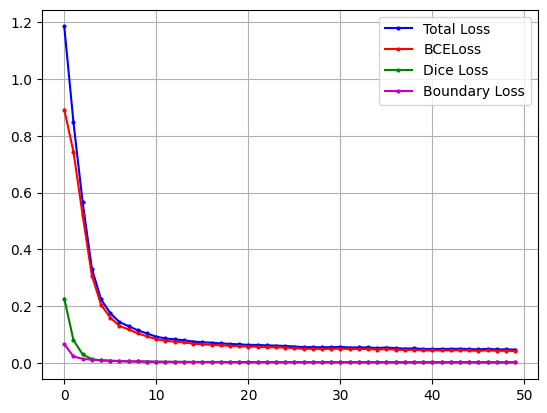

In [ ]:
plt.plot(all_loss_total, linestyle='-', marker='o', color='b', ms=2, label='Total Loss')
plt.plot(all_loss_ce, linestyle='-', marker='o', color='r', ms=2, label='BCELoss')
plt.plot(all_loss_dice, linestyle='-', marker='o', color='g', ms=2, label='Dice Loss')
plt.plot(all_loss_boundary, linestyle='-', marker='o', color='m', ms=2, label='Boundary Loss')
plt.legend()
plt.grid(True)
plt.show()